imprements by https://www.kaggle.com/code/awsaf49/birdclef23-effnet-fsr-cutmixup-train

# Impoert library

In [1]:
import os
import random
from glob import glob
from pathlib import Path
import yaml
from tqdm import tqdm
import IPython.display as ipd

import numpy as np
import pandas as pd

import matplotlib as mpl
cmap = mpl.cm.get_cmap('coolwarm')
import matplotlib.pyplot as plt

import librosa
import wandb
from sklearn import metrics

import torch
from torch import nn
from torch.nn import functional as F
from torch.cuda.amp import autocast, GradScaler

from timm.scheduler import CosineLRScheduler

In [2]:
from config import CFG
from pytorch_model import BirdCLEF23Net
from pytorch_wav2logmel import Wav2Logmel
import pytorch_modeler as modeler
import pytorch_preprocessing as prep
import common as com

In [3]:
modeler.set_seed(CFG.seed)
# setting
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print('Debug :', CFG.debug)

cuda:0
Debug : False


# Wandb

In [4]:
# Try to get the API key from Kaggle secrets
try:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    api_key = user_secrets.get_secret("WANDB")
    # Login to wandb with the API key
    wandb.login(key=api_key)
    print('kaggle notebook mode')
except:
    key_path = '/kaggle/input/wandb_key.txt'
    p = Path(key_path)
    api_key = p.read_text()
    wandb.login(key=api_key)
    print('local mode')

wandb: Currently logged in as: hirokin1999. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


local mode


In [5]:
from datetime import datetime
import pytz

# 日本時間のタイムゾーンを設定
jst = pytz.timezone('Asia/Tokyo')

# 現在時刻を取得し、日本時間に変換
now = datetime.now(jst)

# 現在時刻を文字列に変換
now_str = now.strftime('%Y-%m-%d %H:%M:%S')

print(now_str)

2023-05-06 00:47:12


In [6]:
import yaml
from tqdm import tqdm

def wandb_init(fold):
    config = {k: v for k, v in dict(vars(CFG)).items() if '__' not in k}
    config.update({"fold": int(fold)})
    yaml.dump(config, open(f'./config fold-{fold}.yaml', 'w'), )
    config = yaml.load(open(f'./config fold-{fold}.yaml', 'r'), Loader=yaml.FullLoader)
    run = wandb.init(project="birdclef-2023-public",
                     name=f"fold-{fold}|dim-{CFG.img_size[1]}x{CFG.img_size[0]}|model-{CFG.model_name}|{now_str}",
                     config=config,
                     group=CFG.comment,
                     save_code=True, )
    return run


def log_wandb(valid_df):
    save_df = valid_df.query("miss==True")
    save_df.loc[:, 'pred_name'] = save_df.pred.map(CFG.label2name)
    save_df.loc[:, 'target_name'] = save_df.target.map(CFG.label2name)
    if CFG.debug:
        save_df = save_df.iloc[:CFG.batch_size * CFG.valid_bs]
    noimg_cols = [*CFG.tab_cols, 'target', 'pred', 'target_name', 'pred_name']
    save_df = save_df.loc[:, noimg_cols]

    data = []
    for idx, row in tqdm(save_df.iterrows(), total=len(save_df), desc='wandb ', position=0, leave=True):
        filepath = '/kaggle/input/birdclef-2023/train_audio/' + row.filename
        audio, sr = librosa.load(filepath, sr=None)
        data += [[*row.tolist(), wandb.Audio(audio, caption=row.filename, sample_rate=sr)]]
    wandb_table = wandb.Table(data=data, columns=[*noimg_cols, 'audio'])
    wandb.log({'best': scores,
               'table': wandb_table,
               })

# Data Frame

In [7]:
df = pd.read_csv(f'{CFG.BASE_PATH}/train_metadata.csv')
filename = df.filename.str.replace('.ogg', '.wav')
df['filepath'] = CFG.BASE_PATH + '/train_audio_wav/' + filename
df['target'] = df.primary_label.map(CFG.name2label)
df.head(2)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,url,filename,filepath,target
0,abethr1,[],['song'],4.3906,38.2788,Turdus tephronotus,African Bare-eyed Thrush,Rolf A. de By,Creative Commons Attribution-NonCommercial-Sha...,4.0,https://www.xeno-canto.org/128013,abethr1/XC128013.ogg,/kaggle/input/birdclef-2023/train_audio_wav/ab...,0
1,abethr1,[],['call'],-2.9524,38.2921,Turdus tephronotus,African Bare-eyed Thrush,James Bradley,Creative Commons Attribution-NonCommercial-Sha...,3.5,https://www.xeno-canto.org/363501,abethr1/XC363501.ogg,/kaggle/input/birdclef-2023/train_audio_wav/ab...,0


In [8]:
import ast
from sklearn.preprocessing import MultiLabelBinarizer

df['secondary_labels'] = df['secondary_labels'].apply(ast.literal_eval)
df['multi_labels'] = df.apply(lambda row: [row['primary_label']] + row['secondary_labels'], axis=1)
# mlb = MultiLabelBinarizer()
# mlb.fit(df['multi_labels'])
df['multi_labels'] = df['multi_labels'].astype(str)
df['secondary_labels'] = df['secondary_labels'].astype(str)
# pd.options.display.max_rows = 50
# df['multi_labels'].head(50)

In [9]:
# Import required packages
from sklearn.model_selection import StratifiedKFold

# Initialize the StratifiedKFold object with 5 splits and shuffle the data
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=CFG.seed)

# Reset the index of the dataframe
df = df.reset_index(drop=True)

# Create a new column in the dataframe to store the fold number for each row
df["fold"] = -1

# Iterate over the folds and assign the corresponding fold number to each row in the dataframe
for fold, (train_idx, val_idx) in enumerate(skf.split(df, df['primary_label'])):
    df.loc[val_idx, 'fold'] = fold

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  UserWarning,


# Visualizer

In [10]:
def plot_batch(batch, row=3, col=3, label2name=None,):
    """Plot one batch data"""
    if isinstance(batch, tuple) or isinstance(batch, list):
        audios, tars = batch
    else:
        audios = batch
        tars = None
    plt.figure(figsize=(col*5, row*3))
    for idx in range(row*col):
        ax = plt.subplot(row, col, idx+1)
        plt.plot(audios[idx].numpy(), color=cmap(0.1))
        if tars is not None:
            label = tars[idx].numpy().argmax()
            name = label2name[label]
            plt.title(name)
    plt.tight_layout()
    plt.show()
    
    
def plot_history(history):
    """Plot trainign history, credit: @cdeotte"""
    epochs = len(history.history['auc'])
    plt.figure(figsize=(15,5))
    plt.plot(np.arange(epochs),history.history['auc'],'-o',label='Train AUC',color='#ff7f0e')
    plt.plot(np.arange(epochs),history.history['val_auc'],'-o',label='Val AUC',color='#1f77b4')
    x = np.argmax( history.history['val_auc'] ); y = np.max( history.history['val_auc'] )
    xdist = plt.xlim()[1] - plt.xlim()[0]; ydist = plt.ylim()[1] - plt.ylim()[0]
    plt.scatter(x,y,s=200,color='#1f77b4'); plt.text(x-0.03*xdist,y-0.13*ydist,'max auc\n%.2f'%y,size=14)
    plt.ylabel('AUC (PR)',size=14); plt.xlabel('Epoch',size=14)
    plt.legend(loc=2)
    plt2 = plt.gca().twinx()
    plt2.plot(np.arange(epochs),history.history['loss'],'-o',label='Train Loss',color='#2ca02c')
    plt2.plot(np.arange(epochs),history.history['val_loss'],'-o',label='Val Loss',color='#d62728')
    x = np.argmin( history.history['val_loss'] ); y = np.min( history.history['val_loss'] )
    ydist = plt.ylim()[1] - plt.ylim()[0]
    plt.scatter(x,y,s=200,color='#d62728'); plt.text(x-0.03*xdist,y+0.05*ydist,'min loss',size=14)
    plt.ylabel('Loss',size=14)
    plt.title('Fold %i - Training Plot'%(fold+1),size=18)
    plt.legend(loc=3)
    plt.show()  

# Training

In [11]:
import gc
def gc_collect():
    gc.collect()
    torch.cuda.empty_cache()

In [12]:
def drop_weight(weight):
    target_string='model.classifier'
    drop_keys = [key for key in weight.keys() if target_string in key]
    target_string='att_block'
    drop_keys += [key for key in weight.keys() if target_string in key]
    for key in drop_keys:
        if key in weight:
            del weight[key]
    return weight

# def name2onehot(multi_label_names: torch.Tensor):
#     multi_label_names = [ast.literal_eval(multi_label_name) for multi_label_name in multi_label_names]
#     multi_label_onehot=mlb.transform(multi_label_names)
#     multi_label_onehot=torch.tensor(multi_label_onehot).float()
#     return multi_label_onehot

#########################
#### Training
#### Fold: 1 | Image Size: (224, 313) | Model: tf_efficientnet_b1_ns | Batch Size: 128 | Scheduler: cos
#### Num Train: 19,627 | Num Valid: 3,381


  0%|          | 0/154 [00:00<?, ?it/s]

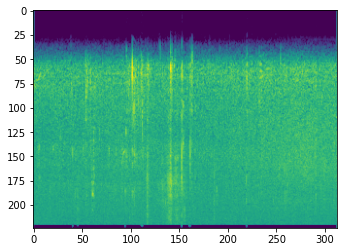

  1%|          | 1/154 [00:05<12:55,  5.07s/it]

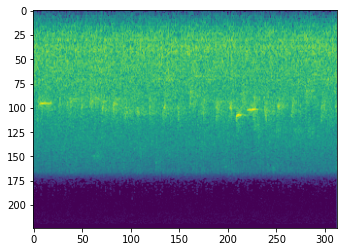

  1%|▏         | 2/154 [00:06<06:55,  2.73s/it]

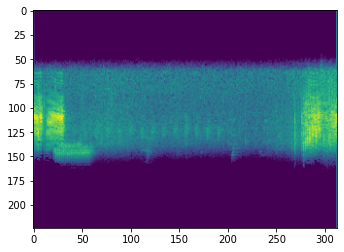

  2%|▏         | 3/154 [00:07<04:59,  1.99s/it]

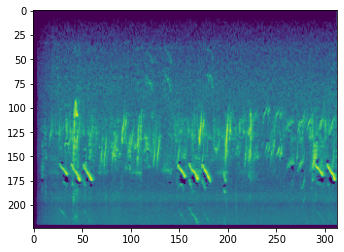

  3%|▎         | 4/154 [00:08<04:06,  1.64s/it]

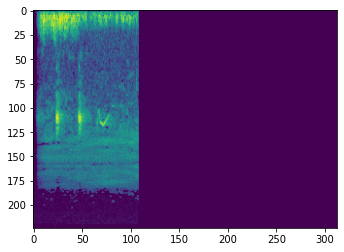

  3%|▎         | 5/154 [00:09<03:35,  1.45s/it]

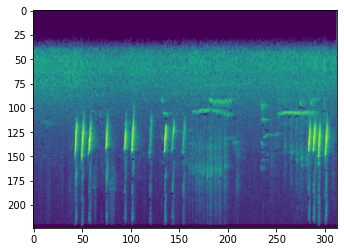

  4%|▍         | 6/154 [00:10<03:18,  1.34s/it]

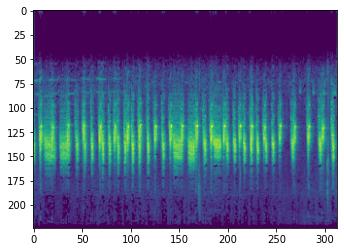

  5%|▍         | 7/154 [00:11<03:04,  1.26s/it]

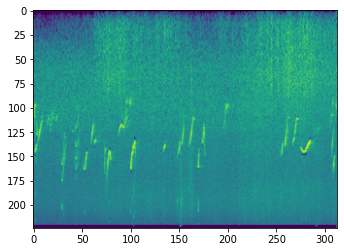

  5%|▌         | 8/154 [00:12<02:55,  1.20s/it]

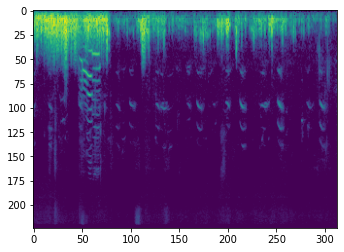

  6%|▌         | 9/154 [00:13<02:50,  1.17s/it]

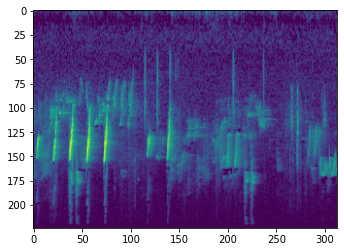

  6%|▋         | 10/154 [00:14<02:42,  1.13s/it]

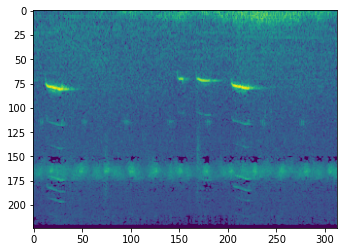

  7%|▋         | 11/154 [00:15<02:38,  1.11s/it]

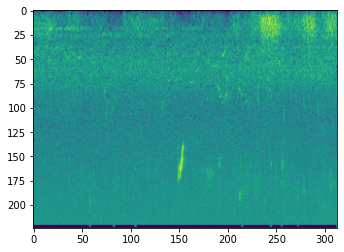

  8%|▊         | 12/154 [00:17<02:34,  1.09s/it]

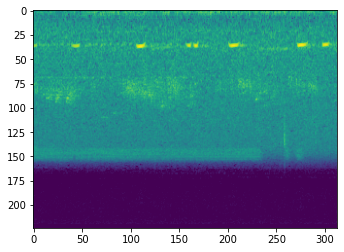

  8%|▊         | 13/154 [00:18<02:34,  1.10s/it]

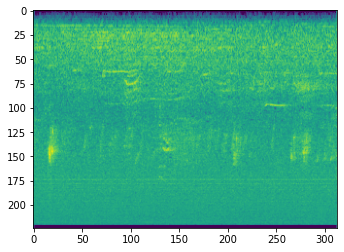

  9%|▉         | 14/154 [00:19<02:32,  1.09s/it]

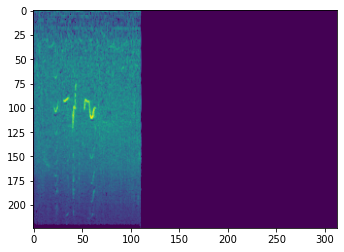

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4fcfa7e560>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1466, in __del__
    self._shutdown_workers()
  File "/opt/conda/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 1430, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/opt/conda/lib/python3.7/multiprocessing/process.py", line 140, in join
    res = self._popen.wait(timeout)
  File "/opt/conda/lib/python3.7/multiprocessing/popen_fork.py", line 45, in wait
    if not wait([self.sentinel], timeout):
  File "/opt/conda/lib/python3.7/multiprocessing/connection.py", line 921, in wait
    ready = selector.select(timeout)
  File "/opt/conda/lib/python3.7/selectors.py", line 415, in select
    fd_event_list = self._selector.poll(timeout)
KeyboardInterrupt: 
  9%|▉         | 14/154 [00:20<03:23,  1.46s/it]


KeyboardInterrupt: 

In [13]:
oof_pred = []; oof_true = []; oof_val = []; oof_ids = []; oof_folds = [] 

num_classes = CFG.num_classes
df = df.copy()
for fold in range(CFG.num_fold):
    scaler = torch.cuda.amp.GradScaler()
    # Check if the fold is selected
    if fold not in CFG.selected_folds:
        continue
    
    # Initialize Weights and Biases
    if CFG.wandb:
        run = wandb_init(fold)
    
    # Compute batch size and number of samples to drop
    infer_bs = CFG.valid_bs
    drop_remainder = CFG.drop_remainder
    
    # Split dataset with cv filter
    if CFG.cv_filter:
        df = com.filter_data(df, thr=5)
        train_df = df.query("fold!=@fold | ~cv").reset_index(drop=True)
        valid_df = df.query("fold==@fold & cv").reset_index(drop=True)
    else:
        train_df = df.query("fold!=@fold").reset_index(drop=True)
        valid_df = df.query("fold==@fold").reset_index(drop=True)
    
    # Upsample train data
    train_df = com.upsample_data(train_df, thr=CFG.upsample_thr)
#     train_df = downsample_data(train_df, thr=500)

    # Get file paths and labels
    train_paths = train_df.filepath.values; train_labels = train_df.target.values
    valid_paths = valid_df.filepath.values; valid_labels = valid_df.target.values

    # Shuffle the file paths and labels
    index = np.arange(len(train_paths))
    np.random.shuffle(index)
    train_paths  = train_paths[index]
    train_labels = train_labels[index]

    # wav
    train_ftype = list(map(lambda x: '.wav' in x, train_paths))
    valid_ftype = list(map(lambda x: '.wav' in x, valid_paths))

    # Compute the number of training and validation samples
    num_train = len(train_paths); num_valid = len(valid_paths)
        
    # Log the number of training and validation samples if Weights and Biases is being used
    if CFG.wandb:
        wandb.log({'num_train':num_train,
                   'num_valid':num_valid})
        
    # Build the training and validation datasets
    # For debugging
    if CFG.debug:
        min_samples = CFG.batch_size
        train_ds = prep.BirdDataset(train_df.iloc[:min_samples], is_train=True)
        valid_ds = prep.BirdDataset(valid_df, is_train=False)
    else:
        train_ds = prep.BirdDataset(train_df, is_train=True)
        valid_ds = prep.BirdDataset(valid_df, is_train=False)
    # dataloader
    train_dataloader, val_dataloader = modeler.make_dataloder(train_ds, valid_ds)
    
    wav_to_logmel = Wav2Logmel(device=device)
    # Clear the session and build the model
    model = BirdCLEF23Net(num_classes=CFG.num_classes)
    # Load birdclef pretrained weights
    # if CFG.pretrain == True:
    #     weight=torch.load(CFG.pretrained_model_path)
    #     weight=drop_weight(weight)
    #     print('load pre-trained model : ', CFG.pretrained_model_path)
    #     print(model.load_state_dict(weight, strict=False))
    model.to(device)
    wav_to_logmel.to(device)
    
    print('#' * 25)
    print('#### Training')
    print('#### Fold: %i | Image Size: (%i, %i) | Model: %s | Batch Size: %i | Scheduler: %s' %
        (fold + 1, *CFG.img_size, CFG.model_name, CFG.batch_size, CFG.scheduler))
    print('#### Num Train: {:,} | Num Valid: {:,}'.format(len(train_paths), len(valid_paths)))

    optimizer = com.get_optimizer(model)
    # TODO com.get_scheduler
    scheduler = CosineLRScheduler(optimizer, t_initial=CFG.epochs, lr_min=CFG.lr_min, 
                                  warmup_t=CFG.warmup_t, warmup_lr_init=CFG.warmup_lr_init, warmup_prefix=True)
    criterion = com.get_criterion()

    best_score = -1
    best_epoch = -1

    for epoch in range(2 if CFG.debug else CFG.epochs):
        # Training
        model.train()
        epoch_loss = 0
        for batch_idx, (inputs, sample_info) in enumerate(tqdm(train_dataloader)):
            inputs, targets = inputs.to(device), sample_info['multi_label_target'].to(device)
            
            optimizer.zero_grad()
            logmel = wav_to_logmel(inputs)
            with torch.cuda.amp.autocast():
                outputs, mix_targets = model(logmel, targets)
                loss = modeler.loss_fn(outputs, mix_targets)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            if np.isinf(loss.item()) or np.isnan(loss.item()):
                print(f'Bad loss, skipping the batch {batch_idx}')
                del loss, outputs, mix_targets
                gc_collect()
                continue
            epoch_loss += loss.item()
            # wandb logger (Train loss)
            run.log({'loss': loss.item()})
        scheduler.step(epoch+1)

        # Validation
        model.eval()
        val_loss = 0
        val_preds = []
        val_true = []
        with torch.no_grad():
            for inputs, sample_info in tqdm(val_dataloader):
                inputs, targets = inputs.to(device), sample_info['multi_label_target'].to(device)
                
                logmel = wav_to_logmel(inputs)
                outputs = model(logmel)
                loss = modeler.loss_fn(outputs, targets)
                outputs = outputs["clipwise_output"]#torch.softmax(outputs, dim=1)
                #outputs = torch.softmax(outputs, dim=1)
                val_loss += loss.item()
                val_preds.append(outputs.detach().cpu().numpy())
                val_true.append(targets.detach().cpu().numpy())

        val_preds = np.vstack(val_preds)
        val_true = np.vstack(val_true)
        # Metrics
        val_score = com.padded_cmap(val_true, val_preds)
        # Checkpoint
        if val_score > best_score:
            best_score = val_score
            best_epoch = epoch + 1
            torch.save(model.state_dict(), f'fold-{fold}.pth')
            art = wandb.Artifact("birdclef-2023", type="model")
            art.add_file(f'fold-{fold}.pth')
            run.log_artifact(art)

        print(f'Epoch: {epoch + 1} | Train Loss: {epoch_loss / len(train_dataloader)} | '
            f'Val Loss: {val_loss / len(val_dataloader)} | Val Padded_cmAP : {val_score}')
        
        # wandb logger
        lr = scheduler.get_epoch_values(epoch)[0]
        run.log({'train_loss': epoch_loss / len(train_dataloader),
                 'lr': lr,
                 'epoch': epoch+1,
                 'valid_loss': val_loss / len(val_dataloader),
                 'valid_padded_cmAP': val_score,})
        
        
    # Load best checkpoint
    print('# Loading best model')
    model.load_state_dict(torch.load(f'fold-{fold}.pth'), strict=False)

    # Predict on the validation data for oof result
    print('# Infering OOF')
    model.eval()
    oof_pred_ = []
    with torch.no_grad():
        for inputs, sample_info in tqdm(val_dataloader):
            inputs, targets = inputs.to(device), sample_info['multi_label_target'].to(device)
            
            logmel = wav_to_logmel(inputs)
            outputs = model(logmel)
            outputs = outputs["clipwise_output"]#torch.softmax(outputs, dim=1)
            oof_pred_.append(outputs.detach().cpu().numpy())
            #print(oof_pred_.shape)

    oof_pred_ = np.concatenate(oof_pred_, axis=0)
    # oof_pred : 5
    oof_pred.append(oof_pred_)

    # Get ids and targets
    oof_true.append(valid_labels)
    oof_folds.append(np.ones_like(oof_true[-1], dtype='int8') * fold)
    oof_ids.append(valid_paths)

    # Save valid data prediction
    y_true = np.array(oof_true[-1])
    y_pred = np.argmax(oof_pred[-1], axis=-1)
    
    valid_df['pred'] = y_pred
    valid_df['miss'] = y_true != y_pred
    valid_df[CFG.class_names] = oof_pred[-1].tolist()
    # Log the metrics
    scores = {}
    cmAP = com.padded_cmap(com.one_hot_encode(y_true), oof_pred[-1])
    oof_val.append(best_score)
    print('\n>>> FOLD %i Primary_Padded_cmAP = %.3f' % (fold+1, cmAP))
    scores.update({'epoch': best_epoch,
                   'primary_cmAP': cmAP,})
    # wandb logger 
    run.log(scores)
    # Show training plot
    # if CFG.training_plot:
    #     plot_history(history)
    # Log metrics, media to wandb
    if CFG.wandb:
        print('# WandB')
        log_wandb(valid_df)
        wandb.run.finish()
        #display(ipd.IFrame(run.url, width=1080, height=720))

# Performance

In [ ]:
def get_id(row):
    row['filename'] = row['filepath'].split('/',5)[-1]
    return row

In [ ]:
from sklearn.metrics import average_precision_score

# OOF Data
y_pred = np.concatenate(oof_pred)
y_true = np.concatenate(oof_true)
ids = np.concatenate(oof_ids)
folds = np.concatenate(oof_folds)

# Overall cmAP
cmAP = com.padded_cmap(com.one_hot_encode(y_true), y_pred)

# Overall AUC in PR curve
# y_true_one_hot = torch.nn.functional.one_hot(torch.tensor(y_true))
# y_pred_tensor = torch.tensor(y_pred)
#auc = average_precision_score(y_true_one_hot.numpy(), y_pred_tensor.numpy(), average='macro')

print('>>> Overall cmAP: ', cmAP)
#print('>>> Overall AUC(PR): ', auc)

## save oof

In [ ]:
# # Save OOF data to disk
# columns = ['filepath', 'fold', 'true', 'pred', *CFG.class_names]
# df_oof = pd.DataFrame(np.concatenate([ids[:,None], folds, y_true,
#                                       np.argmax(y_pred,axis=1)[:,None], y_pred], axis=1), columns=columns)
# df_oof['class_name'] = df_oof.true.map(CFG.label2name)
# df_oof['miss'] = df_oof.true!=df_oof.pred
# tqdm.pandas(desc='id ')
# df_oof = df_oof.progress_apply(get_id,axis=1)
# df_oof.to_csv('oof.csv',index=False)
# display(df_oof.head(2))

# Error Analysis

In [ ]:
# print('Miss Total:')
# display(df_oof.query("miss==True").shape[0])

# print()
# print('Miss Distribution Top10:')
# display(df_oof.query("miss==True").class_name.value_counts()[:10])